In [2]:
import os
# print(os.listdir("C://Users//navin//Dropbox//Ryerson University//CIND 820//complaints"))

import pandas as pd
import numpy as np
import zipfile
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#import warnings

In [3]:
df = pd.read_csv('complaints.csv')
#
#df = pd.read_csv('complaints_sample.csv')
#The dataset can be found on 
#https://catalog.data.gov/dataset/consumer-complaint-database
#our dataset is download on Sept 17, 2020
df.shape

(1757764, 18)

In [4]:
dfNew = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
dfNew = dfNew[pd.notnull(dfNew['Consumer complaint narrative'])]
dfNew = dfNew[pd.notnull(dfNew['Product'])]
# Renaming second column for a simpler name
dfNew.columns = ['Product', 'Consumer_complaint'] 

dfNew.shape

(596333, 2)

In [5]:
dfNew.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other reports', 
              'Credit reporting': 'Credit reporting, repair, or other reports',
              'Credit card': 'Credit card or prepaid card',
              'Prepaid card': 'Credit card or prepaid card',
              'Payday loan': 'Payday loan, title loan, or personal loan',
              'Money transfers': 'Money transfer, virtual currency, or money service',
              'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [6]:
dfNew.head(5)

,Product,Consumer_complaint
0,"Credit reporting, repair, or other reports",Although I am checking for and addressing miss...
1,Debt collection,transworld systems inc. \nis trying to collect...
3,Debt collection,"Over the past 2 weeks, I have been receiving e..."
5,Debt collection,Quickclickloans.com hired an attorney XXXX XXX...
6,"Credit reporting, repair, or other reports","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."


In [7]:
dfNewOriginal=dfNew.copy()
#dfNew=dfNew[:1000]


In [8]:
#Random Sampling
dfNew=dfNew.sample(n=10000, random_state=1)
dfNew.head(5)
dfNew.to_csv ('complaints_samples.csv', index = False, header=True)

PreProcessing

Lowercase

Remove Punctuation

Remove Stop words

Romove Digits

Limmatization


In [9]:
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))

In [10]:
import string
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x:' '.join([char for char in x.split() if char not in string.punctuation]))
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].str.replace(r'[^\w\s]',"")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xx+\s","")

In [11]:
#pip install nltk
from nltk.corpus import stopwords
stopE = stopwords.words('english')
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if char not in stopE]))

In [12]:
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if not char.isdigit()]))

In [14]:
# pip install pattern
# Run this part twice
import pattern

from pattern.en import lemma
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x:' '.join([lemma(wd) for wd in x.split()]))

In [15]:
dfNew.Consumer_complaint.head(10)

1362593    sure happen think exhusband apply receive payd...
146606           please put extend fraud alert credit report
605929     issue unknown inquiry make 3rd party company c...
1589350    significantly affect hurricane harvey tragedy ...
630329     lyone doughty veldhui llp send county court sy...
1421497    call swear phone cause keep fight account mine...
482845     decide get credit pull due bill receive mail n...
1432991    pnc bank respond dispute write since request r...
185726     debit card steal tell acct would credit well f...
367229     midland fund erroneously report collection nev...
Name: Consumer_complaint, dtype: object



Using TF-IDF-vectors, that have been calculated with the entire corpus (training and test subsets combined), while training the model might introduce some data leakage and hence yield in too optimistic performance measures. This is because the IDF-part of the training set's TF-IDF features will then include information from the test set already.

Calculating them completely separately for the training and test set is not a good idea either, because besides testing the quality of your model then you will be also testing the quality of your IDF-estimation. And because the test set is usually small this will be a poor estimation and will worsen your performance measures.

Therefore I would suggest (analogously to the common mean imputation of missing values) to perform TF-IDF-normalization on the training set seperately and then use the IDF-vector from the training set to calculate the TF-IDF vectors of the test set.


In [16]:
from sklearn.model_selection import train_test_split
y = dfNew['Product']
X=dfNew.Consumer_complaint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

TF-IDF Matrix for whole document

In [17]:

vectors = tfidf.fit_transform(dfNew.Consumer_complaint)
feature_names = tfidf.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df1 = pd.DataFrame(denselist, columns=feature_names)
df1.head(20)

,1681i,1692g,1st,2nd,30day,3rd,605b,abide,ability,able,...,xxxxxxxx2015,xxxxxxxx2016,ye,year,yesterday,yet,york,young,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.411785,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.170255,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


Random Forest Classifier 

RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

   n_estimators = number of trees in the foreset
   
    max_features = max number of features considered for splitting a node
    
    max_depth = max number of levels in each decision tree
    
    min_samples_split = min number of data points placed in a node before the node is split
    
    min_samples_leaf = min number of data points allowed in a leaf node
    
    bootstrap = method for sampling data points (with or without replacement)




In [18]:
classifier = RandomForestClassifier(n_estimators=100,  random_state=0)
classifier.fit(X_train_counts, y_train) 
y_pred = classifier.predict(X_test_counts)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3  19   0  12   6   1   0   5   0   0   0   0]
 [  1  38   0  16   9   4   0   0   0   0   0   0]
 [  0   0   0   7  12  10   0   5   0   0   0   0]
 [  0   0   0 146  58   5   0   1   0   0   1   0]
 [  0   2   0  10 755  38   0   7   0   0   1   0]
 [  0   2   0   4  75 294   0  13   0   0   3   0]
 [  0   7   0   9   7   4   5   1   0   0   0   0]
 [  0   1   0   3  22   6   0 205   0   0   1   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   2   0   1   6   9   0   3   0   0   4   0]
 [  0   0   0   1  16  11   0   2   0   0  72   0]
 [  0   0   0   3  13   4   0  11   0   0   0   7]]
                                                    precision    recall  f1-score   support

                           Bank account or service       0.75      0.07      0.12        46
                       Checking or savings account       0.54      0.56      0.55        68
                                     Consumer Loan       0.00      0.00      0.00        34
                  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
classifier = RandomForestClassifier(n_estimators=150,  random_state=0)
classifier.fit(X_train_counts, y_train) 
y_pred = classifier.predict(X_test_counts)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3  19   0  12   6   0   0   6   0   0   0   0]
 [  1  39   0  13  10   4   0   1   0   0   0   0]
 [  0   0   0   4  15  10   0   5   0   0   0   0]
 [  0   0   0 147  57   5   0   1   0   0   1   0]
 [  0   2   0  11 754  38   0   7   0   0   1   0]
 [  0   2   0   5  77 293   0  11   0   0   3   0]
 [  1   5   0   8   6   6   5   2   0   0   0   0]
 [  0   1   0   3  23   6   0 204   0   0   1   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   1   0   1   5   8   0   4   0   0   6   0]
 [  0   0   0   0  15  10   0   3   0   0  74   0]
 [  0   0   0   3  16   4   0  10   0   0   0   5]]
                                                    precision    recall  f1-score   support

                           Bank account or service       0.60      0.07      0.12        46
                       Checking or savings account       0.57      0.57      0.57        68
                                     Consumer Loan       0.00      0.00      0.00        34
                  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Random Hyperparameter Grid
Instead of searching manually to find the best classifier parameter, I use RandomizedSearchCV. 

To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting. On each iteration, the algorithm will choose a difference combination of the features. However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [20]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 99, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 155, 261, 366, 472, 577, 683, 788, 894, 1000]}


The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time.

In [29]:
# Use the random grid to search for best hyperparameters
from sklearn import preprocessing
y = dfNew['Product']
X=dfNew.Consumer_complaint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
enc = preprocessing.LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)
tfidf_vect = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
tfidf_vect.fit(X)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

#It used to work for n_iter=100. However, now it said it is a bid load to handel. 
#I run it for i_iter=4 to show the example of the result but the following parts are written based on the previuos results

#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 4, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_tfidf, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [30]:
print('Best Parameter',rf_random.best_params_)
print('Best score', rf_random.best_score_)
best_rf=rf_random.best_params_

Best Parameter {'n_estimators': 261, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 57, 'bootstrap': False}
Best score 0.749750382852556


In [ ]:
best_rf

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [22]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    
    'n_estimators': [346,366,386],
    'min_samples_split': [1,5,9],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'max_depth': [79,89,99],
    'bootstrap': [False]  
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(xtrain_tfidf, y_train)

best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  6.6min finished


In [23]:
print('Best Classifier parameter', grid_search.best_params_)
print('Best Score',grid_search.best_score_)
print('Best Estimator', grid_search.best_estimator_)
best_rf_grid=grid_search.best_params_


Best Classifier parameter {'bootstrap': False, 'max_depth': 79, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 346}
Best Score 0.7554998048349733
Best Estimator RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=79, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=346,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Final Random Forest Classifier with grid search results

In [33]:
y = dfNew['Product']
X=dfNew.Consumer_complaint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

classifier = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=79, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=346,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
classifier.fit(X_train_counts, y_train) 
y_pred = classifier.predict(X_test_counts)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))



[[  3  21   0  11   5   0   0   6   0   0   0   0]
 [  0  41   0  15   9   3   0   0   0   0   0   0]
 [  0   0   0   7  13   9   0   5   0   0   0   0]
 [  0   0   0 151  51   6   0   2   0   0   1   0]
 [  0   1   0  11 755  36   0   9   0   0   1   0]
 [  0   2   0   3  69 303   0  10   0   0   4   0]
 [  1   7   0   6   7   1  10   1   0   0   0   0]
 [  1   0   0   4  20   6   0 207   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   2   0   1   3   9   0   3   0   0   7   0]
 [  0   0   0   1  16   8   0   3   0   0  74   0]
 [  0   1   0   3  16   2   0  12   0   0   0   4]]
                                                    precision    recall  f1-score   support

                           Bank account or service       0.60      0.07      0.12        46
                       Checking or savings account       0.55      0.60      0.57        68
                                     Consumer Loan       0.00      0.00      0.00        34
                  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


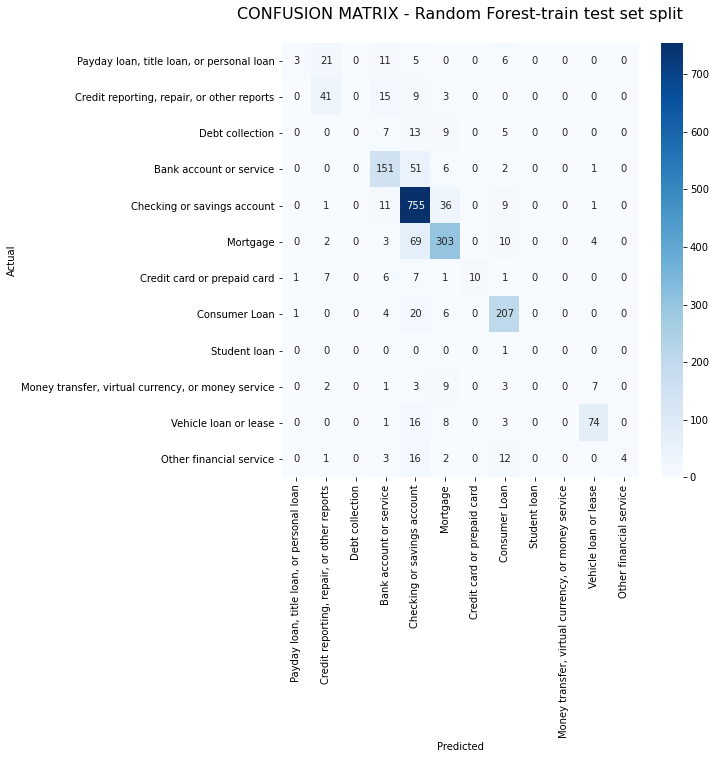

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="Blues", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest-train test set split\n", size=16);

CROSS VALIDATION STRATIFIED KFOLD

In [36]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report
X=dfNew.Consumer_complaint
y=dfNew['Product']
metrics = []
conf_matrix=[]
report_mx=[]
labels_l=['Bank account or service', 'Checking or savings account','Consumer Loan','Credit card or prepaid card',
          'Credit reporting, repair, or other reports','Debt collection',
          'Money transfer, virtual currency, or money service' ,'Mortgage','Other financial service',
          'Payday loan, title loan, or personal loan','Student loan','Vehicle loan or lease'] 

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1)
skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    #vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , stop_words="English")
    vect=CountVectorizer(max_features=1000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    #rf=RandomForestClassifier(n_estimators=200,  random_state=0, max_depth=15, n_jobs=-1 )
    rf=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=99, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=346,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
  
    rf.fit(X_train_dtm, y_train)
    y_pred_class = rf.predict(X_test_dtm)

    metrics.append( accuracy_score(y_test, y_pred_class))
    report_mx.append(classification_report(y_test, y_pred_class))
    conf_matrix.append( confusion_matrix(y_test, y_pred_class, labels=labels_l))

metrics = np.array(metrics)
report_mx = np.array(report_mx)
confusion_mc=sum(conf_matrix)
print('Mean accuracy: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
#print('List Confusion Matrix',conf_matrix)
print(' Confusion Matrix',confusion_mc)
#print('Classification Report',np.mean(report_mx))



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set t

Mean accuracy:  0.7666000000000001
Std for accuracy:  0.011534296684236982
 Confusion Matrix [[  20  115    0   76   31    9    3   14    0    0    1    0]
 [   7  237    0   89   37   18    8   16    0    0    0    0]
 [   0    1    0   15   57   36    1   27    0    0    7    3]
 [   0   16    0  724  202   67    1    4    0    0    1    2]
 [   0    3    0   58 3636  196    0   52    0    0   10    1]
 [   0    8    0   32  338 1595    1   34    0    1   12    1]
 [   1   53    0   35   26   26   58    5    0    0    0    0]
 [   1    1    0   13   90   30    1 1049    0    0    4    0]
 [   0    1    0    0    0    0    0    1    0    0    0    0]
 [   1    4    0   15   26   50    0   31    0    5   19    0]
 [   0    1    1    7   59   35    0   24    0    1  331    0]
 [   0    1    0   19   72   28    1   38    0    0    2   11]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CONFUSION MATRIX - Random Forest: CROSS VALIDATION STRATIFIED 10-FOLD\n')

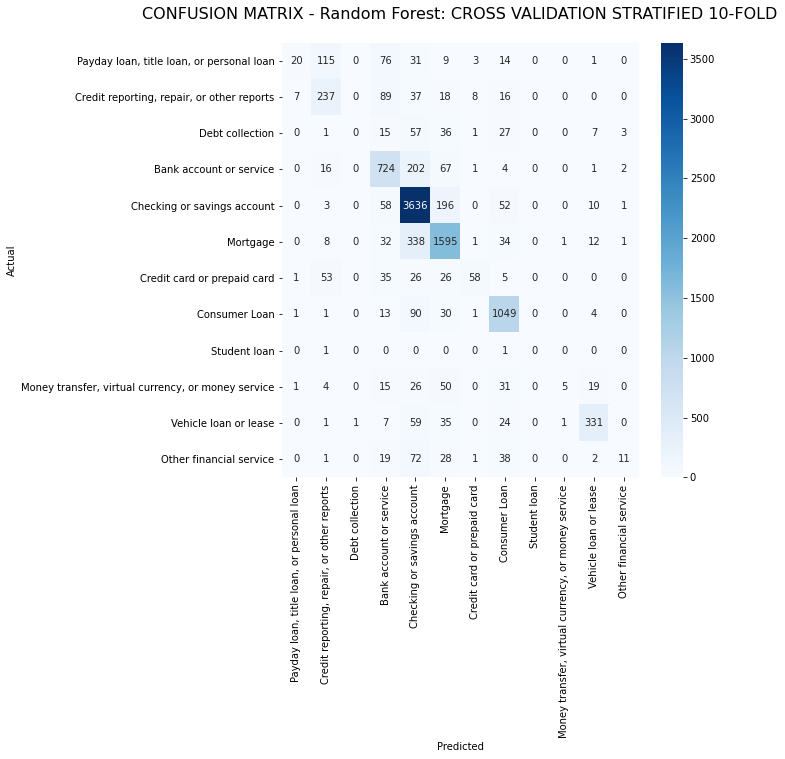

In [37]:

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mc, annot=True, cmap="Blues", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest: CROSS VALIDATION STRATIFIED 10-FOLD\n", size=16)


CROSS VALIDATION STRATIFIED KFOLD

In [39]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
labels_l=['Bank account or service', 'Checking or savings account','Consumer Loan','Credit card or prepaid card',
          'Credit reporting, repair, or other reports','Debt collection',
          'Money transfer, virtual currency, or money service' ,'Mortgage','Other financial service',
          'Payday loan, title loan, or personal loan','Student loan','Vehicle loan or lease'] 
metrics = []
conf_matrix_list_of_arrays=[]
X_train, X_test, y_train, y_test =  model_selection.train_test_split(dfNew.Consumer_complaint, dfNew['Product'], random_state=1)
kf = KFold(n_splits=10, random_state=1)
kf.get_n_splits(X_train)
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    #rf = RandomForestClassifier(n_estimators=100,  random_state=0, max_depth=30, n_jobs=-1)
    rf=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=99, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=346,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    rf.fit(X_train_dtm, y_train)
    y_pred_class = rf.predict(X_test_dtm)
    
    metrics.append( accuracy_score(y_test, y_pred_class))
    conf_matrix_list_of_arrays.append( confusion_matrix(y_test, y_pred_class, labels=labels_l))
    #conf_matrix =conf_matrix+ confusion_matrix(y_test, y_pred_class)
    #conf_matrix_list_of_arrays =conf_matrix_list_of_arrays
    
metrics = np.array(metrics)
confusion_mc1=sum( conf_matrix_list_of_arrays)
print('Mean accuracy: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
#print('List Confusion Matrix',conf_matrix_list_of_arrays)
print(' Confusion Matrix',confusion_mc1)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Mean accuracy:  0.7653000000000001
Std for accuracy:  0.010705606008068866
 Confusion Matrix [[  28  118    0   70   25    8    5   14    0    0    1    0]
 [   7  257    0   68   38   18   11   12    0    0    1    0]
 [   1    1    0   14   62   32    1   13    0    4   12    7]
 [   0   18    0  708  207   70    3    9    0    0    1    1]
 [   0    4    0   66 3600  213    1   54    0    0   16    2]
 [   0    8    0   32  359 1569    2   34    0    2   16    0]
 [   2   53    0   33   22   18   72    2    0    0    2    0]
 [   0    2    0   12   85   35    1 1049    0    0    5    0]
 [   0    1    0    0    0    0    0    1    0    0    0    0]
 [   1    4    0   14   29   49    0   25    0   13   15    1]
 [   0    2    1    6   63   31    0   16    0    3  337    0]
 [   0    1    0   20   68   25    1   32    0    1    4   20]]


Text(0.5, 1.0, 'CONFUSION MATRIX - Random Forest: CROSS VALIDATION 10-FOLD\n')

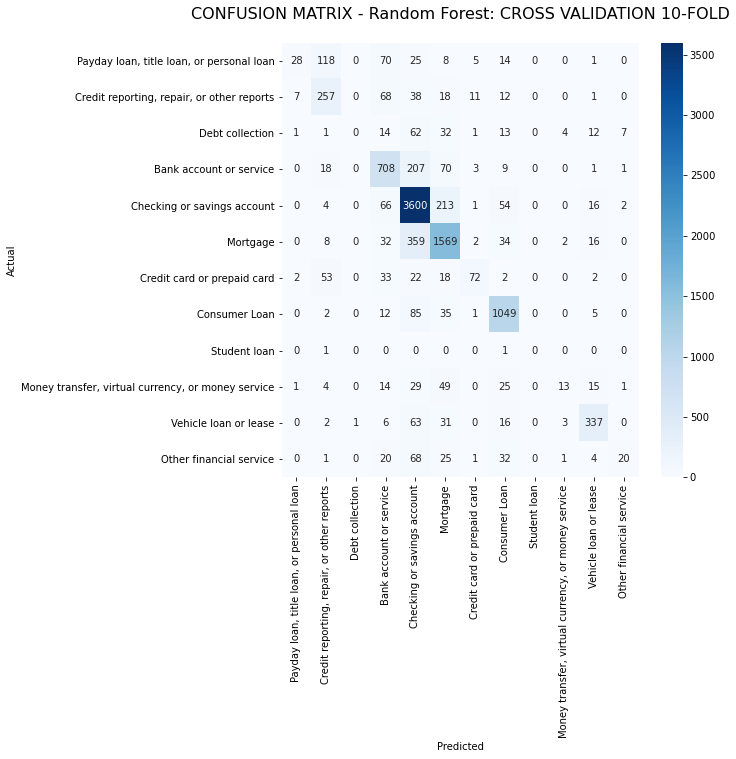

In [40]:

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mc1, annot=True, cmap="Blues", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest: CROSS VALIDATION 10-FOLD\n", size=16)
